# EDA 

**Table of content**

* [Data overveiw](#overview)
* [Analyze alarms data](#alarms)
    * [Alarms distribution in time](#alarms_in_time)
    * [Alarms distribution by regions](#alarms_in_regions)
    * [Alarms distribution by duration](#alarms_durations)
* [Analyze weather data](#weather)
    * [The time interval that the data cover](#weather_time)
    * [Correlation matrix](#corr)
    * [Analyse precipitations over regions](#precipitations)
* [Analyze ISW reports](#reports)
    * [The time interval that the data cover](#reports_time)
    * [N-grams analyzis](#reports_n_grams)
    * [Idf_weights](#reports_idf)
* [Analyze merged data](#merged)
    * [Overview](#merged_overview)
    * [Alarms during precipitations](#alarms_dur_precipitations)

In [96]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from utils import text_preprocessing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import os
import pickle
import pathlib

from IPython.display import display
from collections import Counter

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/vlad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
data_folder = os.path.join(pathlib.Path().resolve(), 'data/data_before_lab_3')
alarms_path = os.path.join(data_folder, 'alarms.csv')
all_weather_by_hour_path = os.path.join(data_folder, 'all_weather_by_hour.csv')
regions_path = os.path.join(data_folder, 'regions.csv')
reports_path = os.path.join(data_folder, 'reports_processed.csv')

In [3]:
alarms = pd.read_csv(alarms_path, sep=';')
weather = pd.read_csv(all_weather_by_hour_path)
regions = pd.read_csv(regions_path)
reports = pd.read_csv(reports_path, sep=';')

## Data overview <a class="anchor" id="overview"></a>

In [4]:
display(regions.head())
display(regions.shape)
display(alarms.head())
display(alarms.shape)
display(weather.head())
display(weather.shape)
display(weather.columns)
display(reports.head())
display(reports.shape)

,region,center_city_ua,center_city_en,region_alt,region_id
0,АР Крим,Сімферополь,Simferopol,Крим,1
1,Вінницька,Вінниця,Vinnytsia,Вінниччина,2
2,Волинська,Луцьк,Lutsk,Волинь,3
3,Дніпропетровська,Дніпро,Dnipro,Дніпропетровщина,4
4,Донецька,Донецьк,Donetsk,Донеччина,5


(25, 5)

,id,region_id,region_title,region_city,all_region,start,end,clean_end,intersection_alarm_id
0,2,3,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NaN
1,4,12,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NaN
2,5,14,Одещина,Одеса,0,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:47:03,NaN
3,6,6,Житомирщина,Житомир,0,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 09:36:36,NaN
4,7,3,Вінниччина,Вінниця,0,2022-02-26 08:39:39,2022-02-26 10:42:41,2022-02-26 10:42:41,NaN


(19933, 9)

,city_latitude,city_longitude,city_resolvedAddress,city_address,city_timezone,city_tzoffset,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,...,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_severerisk,hour_conditions,hour_icon,hour_source,hour_stations
0,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,24.1,89.0,0.0,NaN,0.0,10.0,Partially cloudy,partly-cloudy-night,obs,remote
1,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,24.1,71.1,0.0,NaN,0.0,10.0,Partially cloudy,partly-cloudy-night,obs,remote
2,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,24.1,95.4,0.0,NaN,0.0,10.0,Overcast,cloudy,obs,remote
3,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,24.1,74.6,0.0,NaN,0.0,10.0,Partially cloudy,partly-cloudy-night,obs,remote
4,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,24.1,67.8,0.0,NaN,0.0,10.0,Partially cloudy,partly-cloudy-night,obs,remote


(190656, 67)

Index(['city_latitude', 'city_longitude', 'city_resolvedAddress',
       'city_address', 'city_timezone', 'city_tzoffset', 'day_datetime',
       'day_datetimeEpoch', 'day_tempmax', 'day_tempmin', 'day_temp',
       'day_feelslikemax', 'day_feelslikemin', 'day_feelslike', 'day_dew',
       'day_humidity', 'day_precip', 'day_precipprob', 'day_precipcover',
       'day_snow', 'day_snowdepth', 'day_windgust', 'day_windspeed',
       'day_winddir', 'day_pressure', 'day_cloudcover', 'day_visibility',
       'day_solarradiation', 'day_solarenergy', 'day_uvindex',
       'day_severerisk', 'day_sunrise', 'day_sunriseEpoch', 'day_sunset',
       'day_sunsetEpoch', 'day_moonphase', 'day_conditions', 'day_description',
       'day_icon', 'day_source', 'day_preciptype', 'day_stations',
       'hour_datetime', 'hour_datetimeEpoch', 'hour_temp', 'hour_feelslike',
       'hour_humidity', 'hour_dew', 'hour_precip', 'hour_precipprob',
       'hour_snow', 'hour_snowdepth', 'hour_preciptype', 'hour_windg

,date,url,page_title,content_title,content_html,content_text
0,2022-02-25,https://www.understandingwar.org/backgrounder/...,Russia-Ukraine Warning Update: Russian Offensi...,Russia-Ukraine Warning Update: Russian Offensi...,"<div class=""field field-name-body field-type-t...",\nRussian forces entered major Ukrainian citie...
1,2022-02-26,https://www.understandingwar.org/backgrounder/...,Russia-Ukraine Warning Update: Russian Offensi...,Russia-Ukraine Warning Update: Russian Offensi...,"<div class=""field field-name-body field-type-t...",\nRussian forces’ main axes of advance in the ...
2,2022-02-27,https://www.understandingwar.org/backgrounder/...,Russia-Ukraine Warning Update: Russian Offensi...,Russia-Ukraine Warning Update: Russian Offensi...,"<div class=""field field-name-body field-type-t...",\nThe Russian military has likely recognized t...
3,2022-02-28,https://www.understandingwar.org/backgrounder/...,"Russian Offensive Campaign Assessment, Februar...","Russian Offensive Campaign Assessment, Februar...","<div class=""field field-name-body field-type-t...",\nThe Russian military is reorganizing its mil...
4,2022-03-01,https://www.understandingwar.org/backgrounder/...,"Russian Offensive Campaign Assessment, March 1...","Russian Offensive Campaign Assessment, March 1","<div class=""field field-name-body field-type-t...",\nRussian forces are completing the reinforcem...


(332, 6)

## Analyze alarms data <a class="anchor" id="alarms"></a>

In [5]:
alarms["start"] = pd.to_datetime(alarms["start"])
alarms["end"] = pd.to_datetime(alarms["end"])
alarms["duration"] = alarms["end"] - alarms["start"]

alarms.head()

,id,region_id,region_title,region_city,all_region,start,end,clean_end,intersection_alarm_id,duration
0,2,3,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NaN,0 days 00:46:11
1,4,12,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NaN,0 days 00:49:11
2,5,14,Одещина,Одеса,0,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:47:03,NaN,0 days 00:30:05
3,6,6,Житомирщина,Житомир,0,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 09:36:36,NaN,0 days 01:30:42
4,7,3,Вінниччина,Вінниця,0,2022-02-26 08:39:39,2022-02-26 10:42:41,2022-02-26 10:42:41,NaN,0 days 02:03:02


### Alarms distribution in time <a class="anchor" id="alarms_in_time"></a>

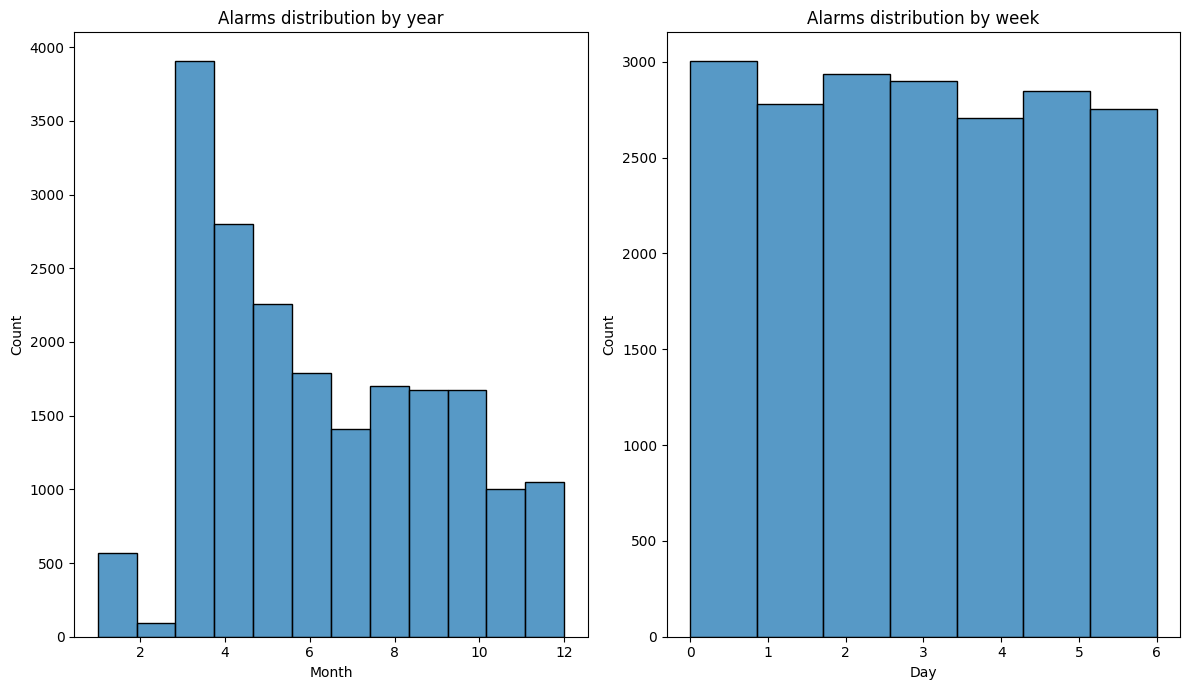

In [6]:
months = alarms["start"].dt.month
days = alarms["start"].dt.dayofweek


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

sns.histplot(data=months, bins=12, ax=ax1).set(xlabel="Month", title="Alarms distribution by year")
sns.histplot(data=days, bins=7, ax=ax2).set(xlabel="Day", title="Alarms distribution by week")
# ax1.hist(months, bins = range(1, 13, 1))
# ax1.set_title("Alarms distribution by months")

# ax2.hist(days, bins = range(1, 32, 1))
# ax2.set_title("Alarms distribution by day")
fig.tight_layout()

According to plots, there is no correlation between days of week and number of alarms. However, we can see that there is low number of alarms in Ferbuary, and high number in March. We can make an assumption, that high number of alarms in March may be due to the fact that March is the first month of the war with a large intensification of hostilities. On the other hand, low number in February leads to [low number of data](#low_num_of_data) from this month.

### Alarms distribution by regions <a class="anchor" id="alarms_in_regions"></a>

/tmp/ipykernel_10909/2610327070.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(regions.unique(), minor=False, rotation=60)


[Text(0, 0, 'Вінниччина'),
 Text(1, 0, 'Львівщина'),
 Text(2, 0, 'Одещина'),
 Text(3, 0, 'Житомирщина'),
 Text(4, 0, 'Рівненщина'),
 Text(5, 0, 'Волинь'),
 Text(6, 0, 'Хмельниччина'),
 Text(7, 0, 'Тернопільщина'),
 Text(8, 0, 'Запоріжжя'),
 Text(9, 0, '️Донеччина'),
 Text(10, 0, 'Дніпропетровщина'),
 Text(11, 0, 'Кіровоградщина'),
 Text(12, 0, 'Київщина'),
 Text(13, 0, 'Чернігівщина'),
 Text(14, 0, 'Черкащина'),
 Text(15, 0, 'Полтавщина'),
 Text(16, 0, 'Миколаївщина'),
 Text(17, 0, 'Буковина'),
 Text(18, 0, 'Івано-Франківщина'),
 Text(19, 0, 'Харківщина'),
 Text(20, 0, 'Сумщина'),
 Text(21, 0, 'Закарпаття'),
 Text(22, 0, 'Херсонщина')]

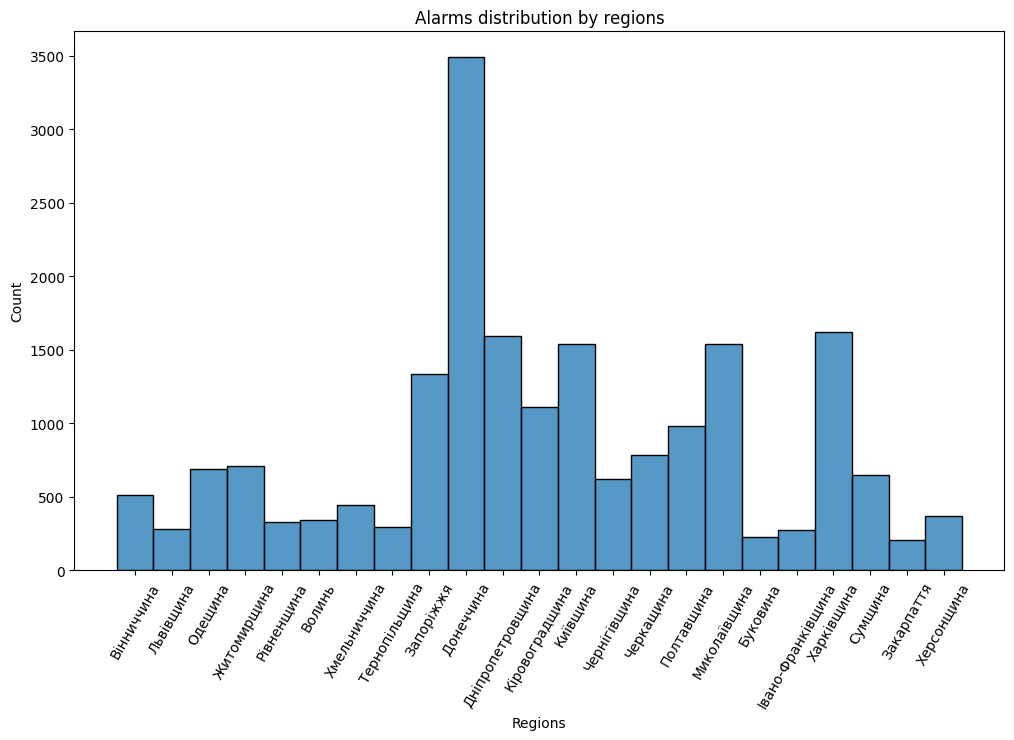

In [7]:
regions = alarms["region_title"]

fig, ax = plt.subplots(figsize=(12, 7))

plot = sns.histplot(data=regions, bins=len(regions))
plot.set_title("Alarms distribution by regions")
plot.set_xlabel("Regions")
plot.set_xticklabels(regions.unique(), minor=False, rotation=60)

Most number of alarms was detected in Donetsk, as expected.

### Alarms distribution by duration <a class="anchor" id="alarms_durations"></a>

[Text(0, 0.5, 'Duration in minutes'),
 Text(0.5, 1.0, 'Alarms distribution by Durations')]

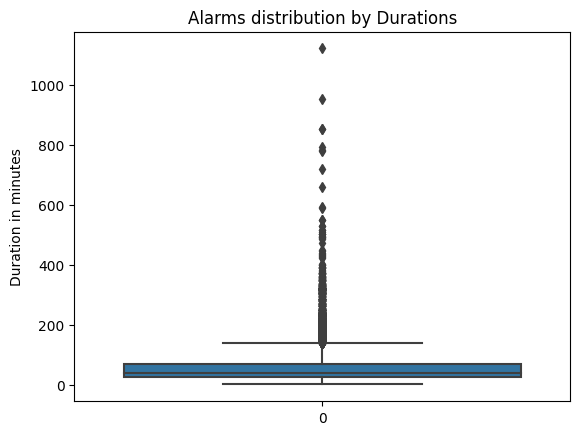

In [8]:
sns.boxplot(data=alarms["duration"].dt.total_seconds()/60).set(ylabel="Duration in minutes", title="Alarms distribution by Durations")

We can see that most frequently alarm duration less than 200 minutes; however, there are a lot of outliners above 200 minutes.

## Analyze weather data <a class="anchor" id="weather"></a>

In [9]:
weather.columns

Index(['city_latitude', 'city_longitude', 'city_resolvedAddress',
       'city_address', 'city_timezone', 'city_tzoffset', 'day_datetime',
       'day_datetimeEpoch', 'day_tempmax', 'day_tempmin', 'day_temp',
       'day_feelslikemax', 'day_feelslikemin', 'day_feelslike', 'day_dew',
       'day_humidity', 'day_precip', 'day_precipprob', 'day_precipcover',
       'day_snow', 'day_snowdepth', 'day_windgust', 'day_windspeed',
       'day_winddir', 'day_pressure', 'day_cloudcover', 'day_visibility',
       'day_solarradiation', 'day_solarenergy', 'day_uvindex',
       'day_severerisk', 'day_sunrise', 'day_sunriseEpoch', 'day_sunset',
       'day_sunsetEpoch', 'day_moonphase', 'day_conditions', 'day_description',
       'day_icon', 'day_source', 'day_preciptype', 'day_stations',
       'hour_datetime', 'hour_datetimeEpoch', 'hour_temp', 'hour_feelslike',
       'hour_humidity', 'hour_dew', 'hour_precip', 'hour_precipprob',
       'hour_snow', 'hour_snowdepth', 'hour_preciptype', 'hour_windg

### The time interval that the data cover <a class="anchor" id="weather_time"></a>

In [10]:
weather["day_datetime"] = pd.to_datetime(weather["day_datetime"])
print(f"First record: {min(weather['day_datetime']).date()}")
print(f"Last record: {max(weather['day_datetime']).date()}")

First record: 2022-02-24
Last record: 2023-01-20


### Correlation matrix <a class="anchor" id="corr"></a>

/tmp/ipykernel_10909/1192379585.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = weather.corr()


<Axes: >

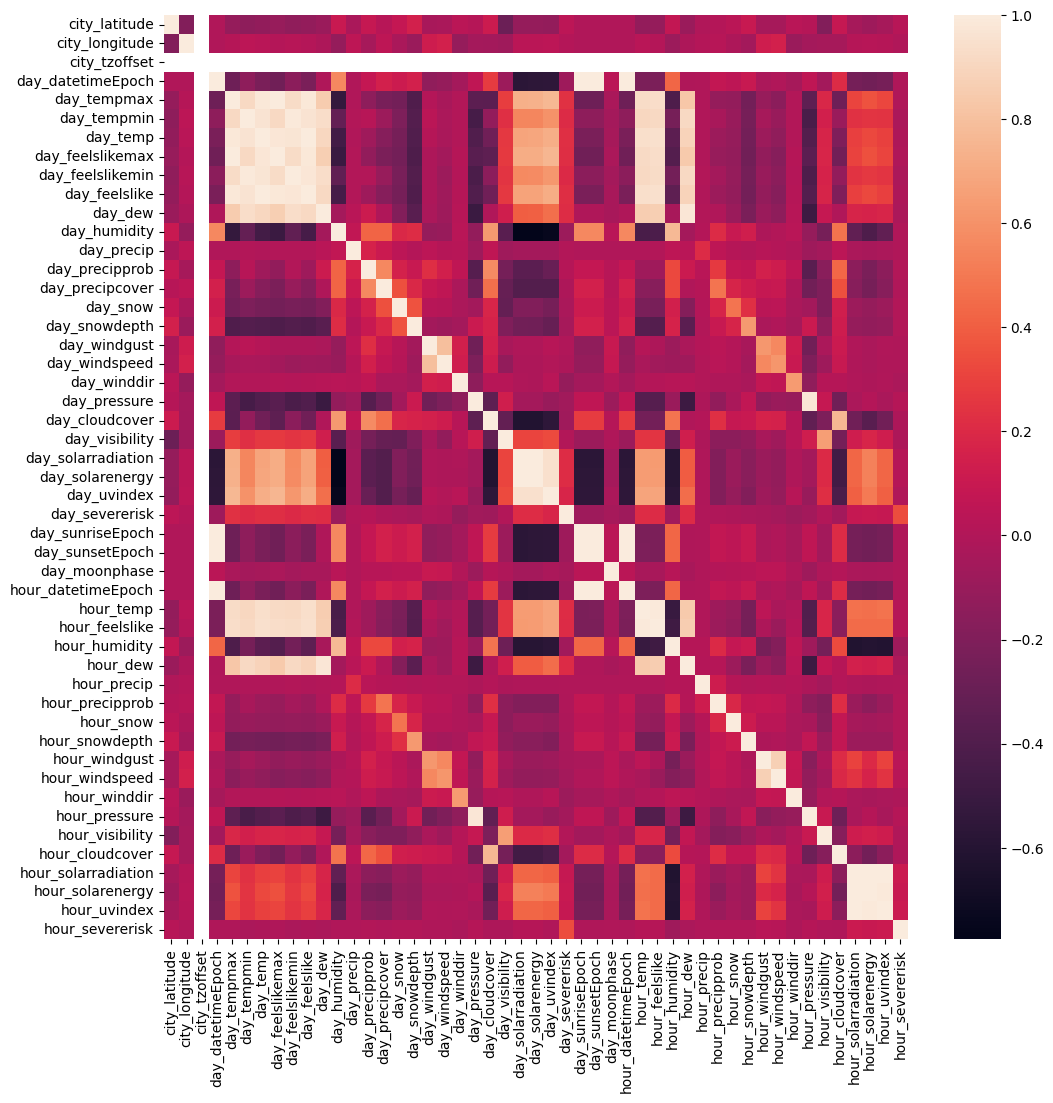

In [11]:
correlation = weather.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(correlation, xticklabels=correlation.columns.values, yticklabels=correlation.columns.values)

### Analyse precipitations over regions <a class="anchor" id="precipitations"></a>

In [31]:
weather["day_conditions"].unique()

array(['Partially cloudy', 'Clear', 'Overcast', 'Snow, Rain, Overcast',
       'Snow, Overcast', 'Snow, Rain, Partially cloudy',
       'Snow, Partially cloudy', 'Rain, Partially cloudy',
       'Rain, Overcast', 'Rain',
       'Snow, Rain, Freezing Drizzle/Freezing Rain, Overcast',
       'Snow, Freezing Drizzle/Freezing Rain, Overcast',
       'Snow, Rain, Freezing Drizzle/Freezing Rain, Partially cloudy',
       'Rain, Freezing Drizzle/Freezing Rain, Overcast',
       'Snow, Freezing Drizzle/Freezing Rain, Partially cloudy',
       'Snow, Rain',
       'Snow, Freezing Drizzle/Freezing Rain, Ice, Overcast',
       'Snow, Rain, Ice, Overcast'], dtype=object)

In [38]:
weather.shape

(190656, 68)

In [13]:
precipitation = ['Snow, Rain, Overcast',
       'Snow, Overcast', 'Snow, Rain, Partially cloudy',
       'Snow, Partially cloudy', 'Rain, Partially cloudy',
       'Rain, Overcast', 'Rain',
       'Snow, Rain, Freezing Drizzle/Freezing Rain, Overcast',
       'Snow, Freezing Drizzle/Freezing Rain, Overcast',
       'Snow, Rain, Freezing Drizzle/Freezing Rain, Partially cloudy',
       'Rain, Freezing Drizzle/Freezing Rain, Overcast',
       'Snow, Freezing Drizzle/Freezing Rain, Partially cloudy',
       'Snow, Rain',
       'Snow, Freezing Drizzle/Freezing Rain, Ice, Overcast',
       'Snow, Rain, Ice, Overcast']

In [33]:
weather["is_precipitation"] = weather["day_conditions"].apply(lambda x: True if x in precipitation else False)

In [34]:
precipitation_by_region = weather.groupby("city_address").is_precipitation.value_counts()

<Axes: xlabel='city_address', ylabel='Count'>

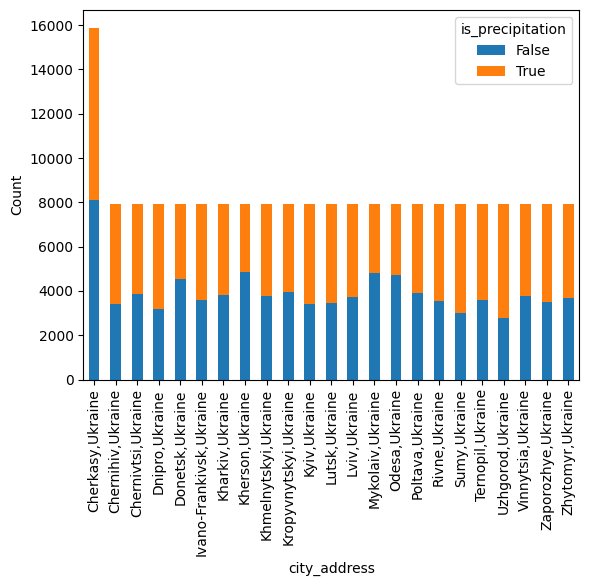

In [35]:
precipitation_by_region.unstack().plot(ylabel="Count", kind='bar', stacked=True)

We can see that there it approximately equal distribution of precipitation over regions, but there are too many records for Cherkasy. It seems that this is some problem with data

In [36]:
weather["city_address"].value_counts()

Cherkasy,Ukraine           15888
Donetsk,Ukraine             7944
Sumy,Ukraine                7944
Ivano-Frankivsk,Ukraine     7944
Lviv,Ukraine                7944
Poltava,Ukraine             7944
Ternopil,Ukraine            7944
Zhytomyr,Ukraine            7944
Rivne,Ukraine               7944
Zaporozhye,Ukraine          7944
Uzhgorod,Ukraine            7944
Khmelnytskyi,Ukraine        7944
Lutsk,Ukraine               7944
Kharkiv,Ukraine             7944
Mykolaiv,Ukraine            7944
Odesa,Ukraine               7944
Chernihiv,Ukraine           7944
Chernivtsi,Ukraine          7944
Kherson,Ukraine             7944
Kyiv,Ukraine                7944
Dnipro,Ukraine              7944
Kropyvnytskyi,Ukraine       7944
Vinnytsia,Ukraine           7944
Name: city_address, dtype: int64

We can see that data from Cherkasy is doubled, so we need to remove duplicate rows.

## Analyze ISW reports <a class="anchor" id="reports"></a>

### The time interval that the data cover <a class="anchor" id="reports_time"></a>

In [18]:
reports["date"] = pd.to_datetime(reports["date"])
print(f"First report: {min(reports['date']).date()}")
print(f"Last report: {max(reports['date']).date()}")

First report: 2022-02-25
Last report: 2023-01-25


We can see that isw reports don't cover Ferbuary, so we have low number of data from this month <a class="anchor" id="low_num_of_data"></a>

In [19]:
# Some functions for preprocessing text data

def preprocess(data):
    data = text_preprocessing.remove_one_letter_word(data)
    data = text_preprocessing.remove_url_from_string(data)
    data = text_preprocessing.convert_lower_case(data)
    data = text_preprocessing.remove_punctuation(data)
    data = text_preprocessing.remove_apostrophe(data)
    data = text_preprocessing.remove_stop_words(data)
    data = text_preprocessing.convert_numbers(data)
    data = text_preprocessing.remove_punctuation(data)
    
    return data

def stemm_text(data, word_root_algo="lemm"):   
    if word_root_algo == "lemm":
        data = text_preprocessing.lemmatizing(data)
    else:
        data = text_preprocessing.stemming(data)
        
    data = text_preprocessing.remove_punctuation(data)
    data = text_preprocessing.remove_stop_words(data)
    
    return data

### N-grams analyzis <a class="anchor" id="reports_n_grams"></a>

In [20]:
reports['content_text'] = reports['content_text'].apply(lambda x: preprocess(x))
text = ' '.join(reports["content_text"])

print(text[:10000])

 russian forces entered major ukrainian cities including kyiv kherson first time february twenty five russian forces main axes advance focused kyiv successfully isolating city banks dnipro river russian military operations along ukraine northern border less well planned organized conducted emanating crimea also less successful far divergence performance likely arises part differences composition organization russian ground forces elements western military district belarus ukraine north southern military district black sea fleet south east isw previously observed determined well organized ukrainian resistance around kyiv kharkiv also played important role preventing russian military advancing speed success reportedly planned russian military deployed additional forces southeastern belarus likely beyond moscow planned use ukraine offset problems challenges russian forces remain much larger capable ukraine conventional military however russia likely defeat ukrainian regular military force

In [21]:
tokens = nltk.word_tokenize(text)

bigrams = list(nltk.ngrams(tokens, 2))
trigrams = list(nltk.ngrams(tokens, 3))
print(bigrams[:10])
print(trigrams[:10])

[('russian', 'forces'), ('forces', 'entered'), ('entered', 'major'), ('major', 'ukrainian'), ('ukrainian', 'cities'), ('cities', 'including'), ('including', 'kyiv'), ('kyiv', 'kherson'), ('kherson', 'first'), ('first', 'time')]
[('russian', 'forces', 'entered'), ('forces', 'entered', 'major'), ('entered', 'major', 'ukrainian'), ('major', 'ukrainian', 'cities'), ('ukrainian', 'cities', 'including'), ('cities', 'including', 'kyiv'), ('including', 'kyiv', 'kherson'), ('kyiv', 'kherson', 'first'), ('kherson', 'first', 'time'), ('first', 'time', 'february')]


In [22]:
def get_most_frequent_n_grams_for_plot(n_grams: list):
    counted_n_grams = Counter(n_grams)
    counted_n_grams = dict(sorted(counted_n_grams.items(), key=lambda x:x[1], reverse=True))
    keys_n_grams = list(map(' '.join ,list(counted_n_grams.keys())[:10]))
    values_n_grams = list(counted_n_grams.values())[:10]
    return keys_n_grams, values_n_grams

[Text(0.5, 0, 'Count'),
 Text(0, 0.5, 'Trigrams'),
 Text(0.5, 1.0, 'Most frequent trigrams')]

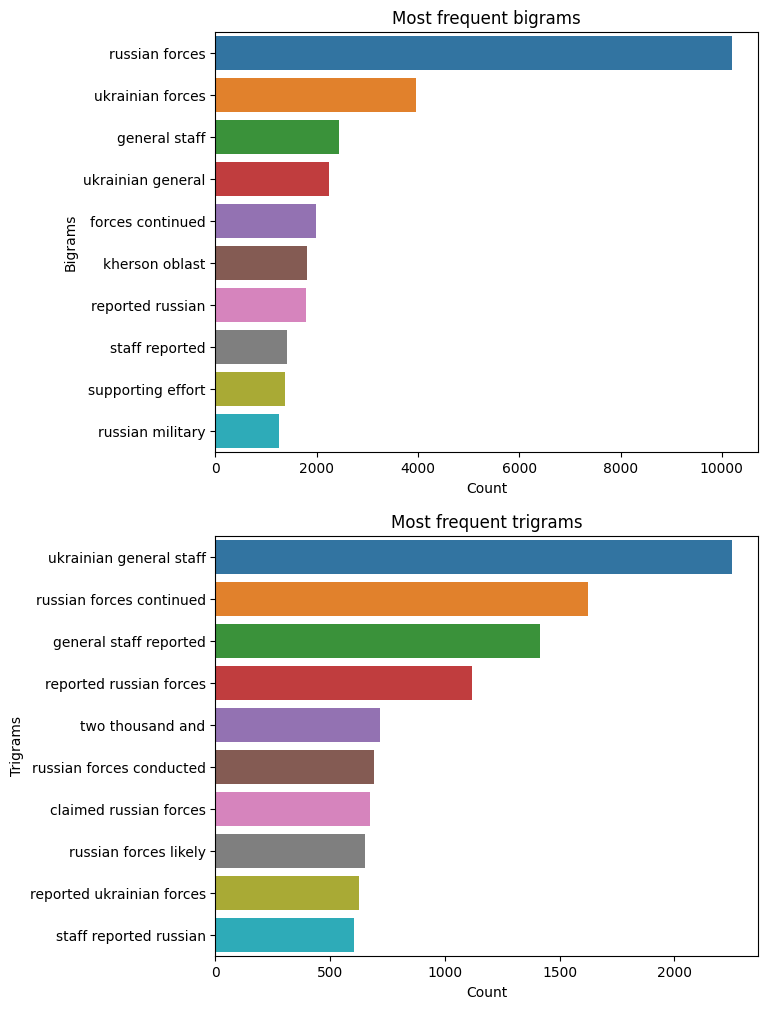

In [23]:
keys_bigrams, values_bigrams = get_most_frequent_n_grams_for_plot(bigrams)
keys_trigrams, values_trigrams = get_most_frequent_n_grams_for_plot(trigrams)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 12))


sns.barplot(
    x = values_bigrams,
    y = keys_bigrams,
    orient='h',
    ax=ax1).set(xlabel="Count", ylabel="Bigrams", title="Most frequent bigrams")

sns.barplot(
    x = values_trigrams,
    y = keys_trigrams,
    orient='h',
    ax=ax2).set(xlabel="Count", ylabel="Trigrams", title="Most frequent trigrams")

### Idf-weights <a class="anchor" id="reports_idf"></a>

In [24]:
reports['content_text_lemm'] = reports['content_text'].apply(lambda x: stemm_text(x, "lemm"))
docs = reports['content_text_lemm'].tolist()

In [25]:
cv = pd.read_pickle(os.path.join(pathlib.Path().resolve(), 'data/isw/count_vectorizer_v1.pkl'))
word_count_vector = cv.fit_transform(docs)

word_count_vector.shape

(332, 8942)

In [27]:
tfidf_transformer = pd.read_pickle(os.path.join(pathlib.Path().resolve(), 'data/isw/tfidf_transformer_v1.pkl'))
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [28]:
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names_out(), columns=["idf_weights"])

df_idf.sort_values(by=["idf_weights"])

,idf_weights
attack,1.021245
war,1.021245
luhansk,1.021245
position,1.024317
combat,1.024317
...,...
skeptical,5.709530
inefficiency,5.709530
inefficient,5.709530
incoherence,5.709530


[Text(0.5, 0, 'idf_weighst'),
 Text(0, 0.5, 'Words'),
 (1.0, 1.05),
 Text(0.5, 1.0, 'Words with lowest idf weights')]

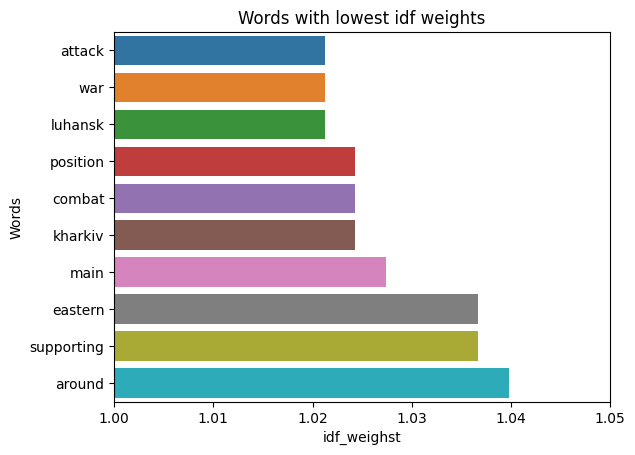

In [29]:
words = df_idf.sort_values(by=["idf_weights"]).index[:10]
idf_weights = list(map(float, df_idf.sort_values(by=["idf_weights"]).values[:10]))

sns.barplot(
    x = idf_weights,
    y = words,
    orient='h').set(xlabel="idf_weighst", ylabel="Words", xlim=(1, 1.05), title="Words with lowest idf weights")


## Analyze merged data <a class="anchor" id="merged"></a>

In [5]:
merged_data = pd.read_csv("./data/merged_data/merged_data.csv", index_col=0)

### Overview <a class="anchor" id="merged_overview"></a>

In [6]:
merged_data.shape

(195085, 64)

In [7]:
merged_data.head()

,city_resolvedAddress,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,...,event_day_date,event_start_hour_datetimeEpoch,event_end_hour_datetimeEpoch,event_hour_level_event_time,event_hour_level_event_datetimeEpoch,isw_report_date,isw_date_tomorrow_datetime,isw_content_text,isw_content_text_lemm,is_alarm
0,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [10]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195085 entries, 0 to 195084
Data columns (total 64 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   city_resolvedAddress                  195085 non-null  object 
 1   day_datetime                          195085 non-null  object 
 2   day_datetimeEpoch                     195085 non-null  int64  
 3   day_tempmax                           195085 non-null  float64
 4   day_tempmin                           195085 non-null  float64
 5   day_temp                              195085 non-null  float64
 6   day_dew                               195085 non-null  float64
 7   day_humidity                          195085 non-null  float64
 8   day_precip                            195085 non-null  float64
 9   day_precipcover                       195085 non-null  float64
 10  day_solarradiation                    195085 non-null  float64
 11  

### Alarms during precipitations <a class="anchor" id="alarms_dur_precipitations"></a>

In [38]:
temp_in_alarms = merged_data[["event_start_hour", "hour_temp"]].drop_duplicates(subset=["event_start_hour"]).dropna()

In [39]:
temp_in_alarms

,event_start_hour,hour_temp
103,2022-02-28 07:00:00,-2.6
106,2022-02-28 09:00:00,-1.6
132,2022-03-01 10:00:00,0.7
154,2022-03-02 08:00:00,0.4
156,2022-03-02 10:00:00,1.0
...,...,...
191232,2022-08-14 08:00:00,20.1
192065,2022-09-17 14:00:00,13.3
192362,2022-09-29 23:00:00,15.4
192667,2022-10-12 16:00:00,14.1


In [46]:
temp_in_alarms["event_start_hour"]

103       2022-02-28 07:00:00
106       2022-02-28 09:00:00
132       2022-03-01 10:00:00
154       2022-03-02 08:00:00
156       2022-03-02 10:00:00
                 ...         
191232    2022-08-14 08:00:00
192065    2022-09-17 14:00:00
192362    2022-09-29 23:00:00
192667    2022-10-12 16:00:00
192777    2022-10-17 05:00:00
Name: event_start_hour, Length: 3496, dtype: object

/tmp/ipykernel_12994/2125372587.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


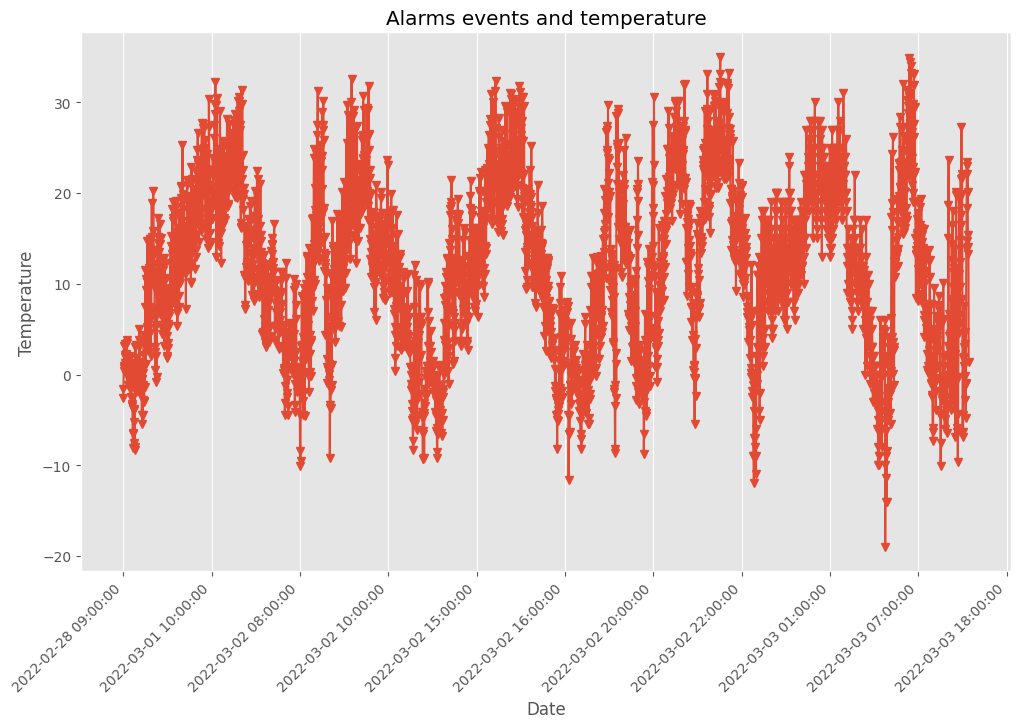

In [97]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot_date(temp_in_alarms.event_start_hour, temp_in_alarms.hour_temp, 'v-')

ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.xaxis.set_major_locator(dates.YearLocator())

ax.set_xlabel("Date")
ax.set_ylabel("Temperature")
ax.set_title("Alarms events and temperature")
plt.show()

<a class="anchor" id="low_num_of_data"></a>